# Address Segmentation
Conversion of address points into segmented address ranges along a road network.

**Notes:** The following guide assumes data has already been preprocessed including data scrubbing and filtering.

In [1]:
import contextily as ctx
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import shapely
from bisect import bisect
from collections import OrderedDict
from IPython.display import display_html
from matplotlib_scalebar.scalebar import ScaleBar
from operator import itemgetter
from shapely.geometry import LineString, Point

# Define index of example roadseg segment.
ex_idx = 153421
ex_place = "British Columbia"

# Define join fields.
join_roadseg = "L_STNAME_C"
join_addresses = "street"

# Define helper functions.
def groupby_to_list(df, group_field, list_field):
    """
    Helper function: faster alternative to pandas groupby.apply/agg(list).
    Groups records by one or more fields and compiles an output field into a list for each group.
    """
    
    if isinstance(group_field, list):
        for field in group_field:
            if df[field].dtype.name != "geometry":
                df[field] = df[field].astype("U")
        transpose = df.sort_values(group_field)[[*group_field, list_field]].values.T
        keys, vals = np.column_stack(transpose[:-1]), transpose[-1]
        keys_unique, keys_indexes = np.unique(keys.astype("U") if isinstance(keys, np.object) else keys, 
                                              axis=0, return_index=True)
    
    else:
        keys, vals = df.sort_values(group_field)[[group_field, list_field]].values.T
        keys_unique, keys_indexes = np.unique(keys, return_index=True)
    
    vals_arrays = np.split(vals, keys_indexes[1:])
    
    return pd.Series([list(vals_array) for vals_array in vals_arrays], index=keys_unique).copy(deep=True)

## Step 1. Load dataframes and configure attributes
Loads dataframes into geopandas and separates address numbers and suffixes, if required.

In [2]:
# Load dataframes.
addresses = gpd.read_file("C:/scratch/British_Columbia.gpkg", layer="addresses")
roadseg = gpd.read_file("C:/scratch/British_Columbia.gpkg", layer="roads")

# Configure attributes - number and suffix.
addresses["suffix"] = addresses["number"].map(lambda val: re.sub(pattern="\\d+", repl="", string=val, flags=re.I))
addresses["number"] = addresses["number"].map(lambda val: re.sub(pattern="[^\\d]", repl="", string=val, flags=re.I)).map(int)

In [3]:
addresses.head()

,id,unit,number,street,city,district,region,postcode,hash,geometry,suffix
0,,,3921,SKI HILL RD,WELLS,,,,d0ebce94b7d8ed1f,POINT (-13532929.245 7001858.048),
1,,,3933,SOLIBAKKE DR,WELLS,,,,d1d9f24d322ee794,POINT (-13532942.270 7001824.062),
2,,,4214,BLAIR AVE,WELLS,,,,a8fd21bb5a8ae72f,POINT (-13533204.761 7002268.409),
3,,,2357,POOLEY ST,WELLS,,,,09c242ee7afafc7a,POINT (-13533195.733 7002249.107),
4,,,2348,BOWMAN CRES,WELLS,,,,29377bc309e62448,POINT (-13533222.962 7002114.475),


In [4]:
roadseg[["NID", "L_STNAME_C", "L_PLACENAM", "R_STNAME_C", "R_PLACENAM", "geometry"]].head()

,NID,L_STNAME_C,L_PLACENAM,R_STNAME_C,R_PLACENAM,geometry
0,d30bf68154764fdf9bc15e77827ac6c2,14TH ST S,Golden,14TH ST S,Golden,"LINESTRING (-13021134.102 6672991.028, -130208..."
1,d30bf68154764fdf9bc15e77827ac6c2,15TH ST S,Golden,15TH ST S,Golden,"LINESTRING (-13021136.105 6672820.854, -130208..."
2,d30bf68154764fdf9bc15e77827ac6c2,8TH AVE S,Golden,8TH AVE S,Golden,"LINESTRING (-13020869.161 6672823.346, -130208..."
3,d30bf68154764fdf9bc15e77827ac6c2,7TH AVE S,Golden,7TH AVE S,Golden,"LINESTRING (-13021136.105 6672820.854, -130211..."
4,85072fef26b648bb99da9f5ed5086463,FOLKESTONE WAY,West Vancouver,FOLKESTONE WAY,West Vancouver,"LINESTRING (-13711493.456 6333861.705, -137113..."


## Preview data
**Note:** this code block is for visual purposes only.

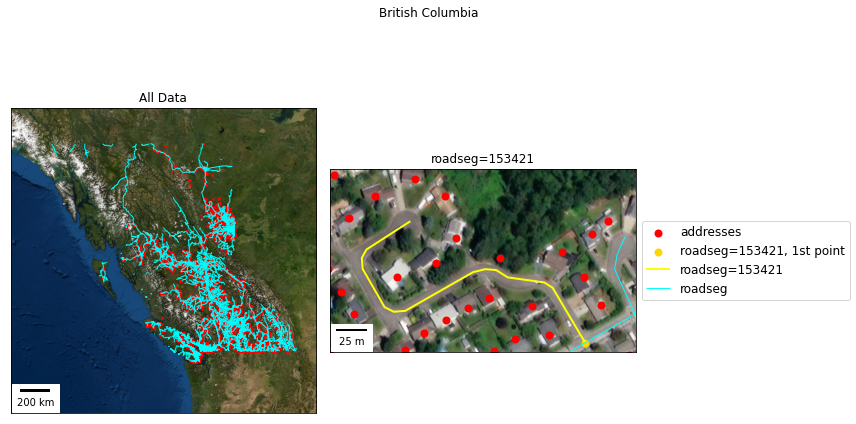

In [5]:
# Fetch basemaps.
# Note: basemaps are retrieved in EPSG:3857 and, therefore, dataframes should also use this crs.
basemaps = list()
basemaps.append(ctx.bounds2img(*roadseg.total_bounds, ll=False, source=ctx.providers.Esri.WorldImagery))
basemaps.append(ctx.bounds2img(*roadseg.loc[roadseg.index==ex_idx].total_bounds, ll=False, zoom=19,
                               source=ctx.providers.Esri.WorldImagery))

# Configure local positional distortion (for scalebar dx parameter).
ymin, ymax = itemgetter(1, 3)(roadseg[roadseg.index==ex_idx].to_crs("EPSG:4617").total_bounds)
lat = ymin + ((ymax - ymin) / 2)
dx = math.cos(math.radians(lat))

# Create data for viewing.
starting_pt = gpd.GeoDataFrame(geometry=[Point(roadseg.loc[roadseg.index==ex_idx]["geometry"].iloc[0].coords[0])], 
                               crs=addresses.crs)

# Configure plots.
fig, ax = plt.subplots(1, 2, figsize=(12, 7), tight_layout=True)
for plt_idx, title in enumerate(["All Data", f"roadseg={ex_idx}"]):
    ax[plt_idx].imshow(basemaps[plt_idx][0], extent=basemaps[plt_idx][1])
    if plt_idx == 0:
        addresses.plot(ax=ax[plt_idx], color="red", label="addresses", markersize=2)
        roadseg.plot(ax=ax[plt_idx], color="cyan", label="roadseg", linewidth=1)
    else:
        addresses.plot(ax=ax[plt_idx], color="red", label="addresses", linewidth=2)
        starting_pt.plot(ax=ax[plt_idx], color="gold", label=f"roadseg={ex_idx}, 1st point", linewidth=2)
        roadseg.loc[roadseg.index==ex_idx].plot(ax=ax[plt_idx], color="yellow", label=f"roadseg={ex_idx}", linewidth=2)
        roadseg.loc[roadseg.index!=ex_idx].plot(ax=ax[plt_idx], color="cyan", label="roadseg", linewidth=1)
    ax[plt_idx].add_artist(ScaleBar(dx=dx, units="m", location="lower left", pad=0.5, color="black"))
    ax[plt_idx].axes.xaxis.set_visible(False)
    ax[plt_idx].axes.yaxis.set_visible(False)
    ax[plt_idx].set_title(title, fontsize=12)
    ax[plt_idx].set_xlim(itemgetter(0, 1)(basemaps[plt_idx][1]))
    ax[plt_idx].set_ylim(itemgetter(2, 3)(basemaps[plt_idx][1]))

plt.suptitle(ex_place, fontsize=12)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=12)
plt.show()

## Step 2. Configure address to roadseg linkages
Links addresses to the nearest, matching road segment.

In [6]:
# Link addresses and roadseg on join fields.
addresses["addresses_index"] = addresses.index
roadseg["roadseg_index"] = roadseg.index

merge = addresses.merge(roadseg[[join_roadseg, "roadseg_index"]], how="left", left_on=join_addresses, right_on=join_roadseg)
addresses["roadseg_index"] = groupby_to_list(merge, "addresses_index", "roadseg_index")

addresses.drop(columns=["addresses_index"], inplace=True)
roadseg.drop(columns=["roadseg_index"], inplace=True)

# Discard non-linked addresses.
addresses.drop(addresses[addresses["roadseg_index"].map(itemgetter(0)).isna()].index, axis=0, inplace=True)

# Convert linkages to integer tuples, if possible.
def as_int(val):
    try:
        return int(val)
    except ValueError:
        return val
addresses["roadseg_index"] = addresses["roadseg_index"].map(lambda vals: tuple(set(map(as_int, vals))))

addresses.head()

,id,unit,number,street,city,district,region,postcode,hash,geometry,suffix,roadseg_index
0,,,3921,SKI HILL RD,WELLS,,,,d0ebce94b7d8ed1f,POINT (-13532929.245 7001858.048),,"(246857, 257419, 134032, 148093, 62046)"
1,,,3933,SOLIBAKKE DR,WELLS,,,,d1d9f24d322ee794,POINT (-13532942.270 7001824.062),,"(213915, 127620)"
2,,,4214,BLAIR AVE,WELLS,,,,a8fd21bb5a8ae72f,POINT (-13533204.761 7002268.409),,"(106881, 116067, 15399, 243112, 162056, 189016..."
3,,,2357,POOLEY ST,WELLS,,,,09c242ee7afafc7a,POINT (-13533195.733 7002249.107),,"(64055, 62376, 45355, 11180, 13236, 23863, 123..."
4,,,2348,BOWMAN CRES,WELLS,,,,29377bc309e62448,POINT (-13533222.962 7002114.475),,"(125826,)"


In [7]:
# Reduce linkages to one roadseg index per address.

def get_nearest_linkage(pt, roadseg_indexes):
    """Returns the roadseg index associated with the nearest roadseg geometry to the given address point."""
    
    # Get roadseg geometries.
    roadseg_geometries = tuple(map(lambda index: roadseg["geometry"].iloc[index], roadseg_indexes))
    
    # Get roadseg distances from address point.
    roadseg_distances = tuple(map(lambda road: pt.distance(road), roadseg_geometries))
    
    # Get the roadseg index associated with the smallest distance.
    roadseg_index = roadseg_indexes[roadseg_distances.index(min(roadseg_distances))]
    
    return roadseg_index


# Flag plural linkages.
flag_plural = addresses["roadseg_index"].map(len) > 1

# Reduce plural linkages to the road segment with the lowest (nearest) geometric distance.
addresses.loc[flag_plural, "roadseg_index"] = addresses[flag_plural][["geometry", "roadseg_index"]].apply(
    lambda row: get_nearest_linkage(*row), axis=1)

# Unpack first tuple element for singular linkages.
addresses.loc[~flag_plural, "roadseg_index"] = addresses[~flag_plural]["roadseg_index"].map(itemgetter(0))

# Compile linked roadseg geometry for each address.
addresses["roadseg_geometry"] = addresses.merge(
    roadseg["geometry"], how="left", left_on="roadseg_index", right_index=True)["geometry_y"]

addresses.head()

,id,unit,number,street,city,district,region,postcode,hash,geometry,suffix,roadseg_index,roadseg_geometry
0,,,3921,SKI HILL RD,WELLS,,,,d0ebce94b7d8ed1f,POINT (-13532929.245 7001858.048),,257419,"LINESTRING (-13532893.746 7001832.295, -135329..."
1,,,3933,SOLIBAKKE DR,WELLS,,,,d1d9f24d322ee794,POINT (-13532942.270 7001824.062),,127620,"LINESTRING (-13532970.523 7001707.719, -135329..."
2,,,4214,BLAIR AVE,WELLS,,,,a8fd21bb5a8ae72f,POINT (-13533204.761 7002268.409),,84781,"LINESTRING (-13533229.040 7002221.776, -135332..."
3,,,2357,POOLEY ST,WELLS,,,,09c242ee7afafc7a,POINT (-13533195.733 7002249.107),,11180,"LINESTRING (-13533313.353 7001907.979, -135332..."
4,,,2348,BOWMAN CRES,WELLS,,,,29377bc309e62448,POINT (-13533222.962 7002114.475),,125826,"LINESTRING (-13533465.995 7002164.964, -135334..."


## Step 3. Configure address parity
Computes address-roadseg parity (left / right side).

In [8]:
def get_parity(pt, vector):
    """
    Determines the parity (left or right side) of an address point relative to a roadseg vector.

    Parity is derived from the determinant of the vectors formed by the road segment and the address-to-roadseg
    vectors. A positive determinant indicates 'left' parity and negative determinant indicates 'right' parity.
    """
    
    det = (vector[1][0] - vector[0][0]) * (pt.y - vector[0][1]) - \
          (vector[1][1] - vector[0][1]) * (pt.x - vector[0][0])
    sign = np.sign(det)
    
    return "l" if sign == 1 else "r"

def get_road_vector(pt, segment):
    """
    Returns the following:
    a) the distance of the address intersection along the road segment.
    b) the vector comprised of the road segment coordinates immediately before and after the address
    intersection point.
    """
    
    # For all road segment points and the intersection point, calculate the distance along the road segment.
    # Note: always use the length as the distance for the last point to avoid distance=0 for looped roads.
    node_distance = (*map(lambda coord: segment.project(Point(coord)), segment.coords[:-1]), segment.length)
    intersection_distance = segment.project(pt)
    
    # Compute the index of the intersection point within the road segment points, based on distances.
    intersection_index = bisect(node_distance, intersection_distance)
    
    # Conditionally compile the road segment points, as a vector, immediately bounding the intersection point.
    
    # Intersection matches a pre-existing road segment point.
    if intersection_distance in node_distance:
        
        # Intersection matches the first road segment point.
        if intersection_index == 1:
            vector = itemgetter(intersection_index - 1, intersection_index)(segment.coords)
        
        # Intersection matches the last road segment point.
        elif intersection_index == len(node_distance):
            vector = itemgetter(intersection_index - 2, intersection_index - 1)(segment.coords)
        
        # Intersection matches an interior road segment point.
        else:
            vector = itemgetter(intersection_index - 2, intersection_index)(segment.coords)
    
    # Intersection matches no pre-existing road segment point.
    else:
        vector = itemgetter(intersection_index - 1, intersection_index)(segment.coords)
    
    return intersection_distance, vector

# Get point of intersection between each address and the linked road segment.
addresses["intersection"] = addresses[["geometry", "roadseg_geometry"]].apply(
    lambda row: itemgetter(-1)(shapely.ops.nearest_points(*row)), axis=1)

# Get the following:
# a) the distance of the intersection point along the linked road segment.
# b) the road segment vector which bounds the intersection point.
#    i.e. vector formed by the coordinates immediately before and after the intersection point.
results = addresses[["intersection", "roadseg_geometry"]].apply(lambda row: get_road_vector(*row), axis=1)
addresses["distance"] = results.map(itemgetter(0))
addresses["roadseg_vector"] = results.map(itemgetter(1))

# Get address parity.
addresses["parity"] = addresses[["geometry", "roadseg_vector"]].apply(
    lambda row: get_parity(*row), axis=1)

addresses[["geometry", "roadseg_geometry", "intersection", "distance", "roadseg_vector", "parity"]].head()

,geometry,roadseg_geometry,intersection,distance,roadseg_vector,parity
0,POINT (-13532929.245 7001858.048),"LINESTRING (-13532893.746 7001832.295, -135329...",POINT (-13532910.86408687 7001867.090980016),38.779276,"((-13532893.745557737, 7001832.294597431), (-1...",l
1,POINT (-13532942.270 7001824.062),"LINESTRING (-13532970.523 7001707.719, -135329...",POINT (-13532910.16518263 7001796.862830841),107.655520,"((-13532970.522610538, 7001707.718611422), (-1...",l
2,POINT (-13533204.761 7002268.409),"LINESTRING (-13533229.040 7002221.776, -135332...",POINT (-13533221.46814516 7002273.315294753),52.269814,"((-13533225.27726522, 7002260.343540964), (-13...",r
3,POINT (-13533195.733 7002249.107),"LINESTRING (-13533313.353 7001907.979, -135332...",POINT (-13533217.56927814 7002214.531952393),385.702033,"((-13533169.940346345, 7002184.4515282195), (-...",r
4,POINT (-13533222.962 7002114.475),"LINESTRING (-13533465.995 7002164.964, -135334...",POINT (-13533253.76754684 7002138.729419757),249.769503,"((-13533267.38942859, 7002121.428145667), (-13...",r


## View relationship between parity variables
View the relationship between address points, bounding roadseg vectors, address-roadseg intersection points, and the computed parity.

**Note:** this code block is for visual purposes only.

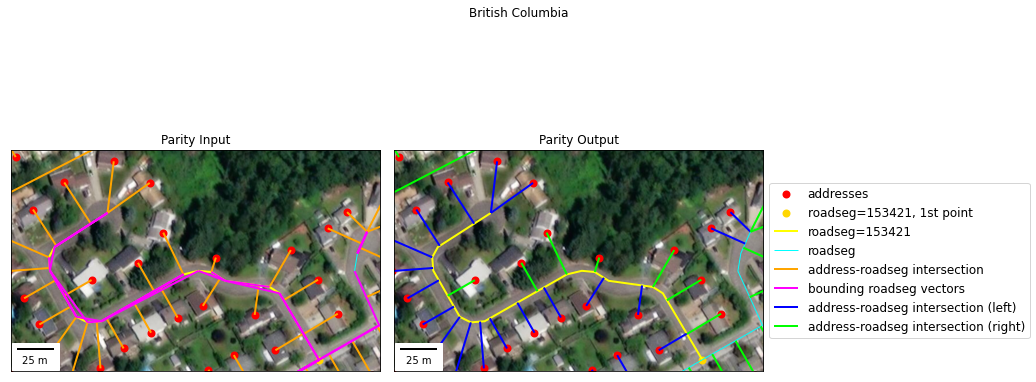

In [9]:
# Create geometries for viewing.
bounding_vectors = gpd.GeoDataFrame(geometry=addresses["roadseg_vector"].map(LineString), crs=addresses.crs)
intersection = gpd.GeoDataFrame(addresses["parity"], geometry=addresses[["geometry", "intersection"]].apply(
    lambda row: LineString([pt.coords[0][:2] for pt in row]), axis=1), crs=addresses.crs)

# Configure plots.
fig, ax = plt.subplots(1, 2, figsize=(14.5, 7), tight_layout=True)
for plt_idx, title in enumerate(["Parity Input", "Parity Output"]):
    ax[plt_idx].imshow(basemaps[1][0], extent=basemaps[1][1])
    addresses.plot(ax=ax[plt_idx], color="red", label="addresses", linewidth=2)
    starting_pt.plot(ax=ax[plt_idx], color="gold", label=f"roadseg={ex_idx}, 1st point", linewidth=2)
    roadseg.loc[roadseg.index==ex_idx].plot(ax=ax[plt_idx], color="yellow", label=f"roadseg={ex_idx}", linewidth=2)
    roadseg.loc[roadseg.index!=ex_idx].plot(ax=ax[plt_idx], color="cyan", label="roadseg", linewidth=1)
    if plt_idx == 0:
        intersection.plot(ax=ax[plt_idx], color="orange", label="address-roadseg intersection", linewidth=2)
        bounding_vectors.plot(ax=ax[plt_idx], color="magenta", label="bounding roadseg vectors", linewidth=2)
    else:
        intersection.loc[intersection["parity"]=="l"].plot(
            ax=ax[plt_idx], color="blue", label="address-roadseg intersection (left)", linewidth=2)
        intersection.loc[intersection["parity"]=="r"].plot(
            ax=ax[plt_idx], color="lime", label="address-roadseg intersection (right)", linewidth=2)
    ax[plt_idx].add_artist(ScaleBar(dx=dx, units="m", location="lower left", pad=0.5, color="black"))
    ax[plt_idx].axes.xaxis.set_visible(False)
    ax[plt_idx].axes.yaxis.set_visible(False)
    ax[plt_idx].set_title(title, fontsize=12)
    ax[plt_idx].set_xlim(itemgetter(0, 1)(basemaps[1][1]))
    ax[plt_idx].set_ylim(itemgetter(2, 3)(basemaps[1][1]))

plt.suptitle(ex_place, fontsize=12)
legend_icons = list()
legend_labels = list()
for axis in ax:
    legend_items = list(zip(*[items for items in zip(*axis.get_legend_handles_labels()) if items[1] not in legend_labels]))
    legend_icons.extend(legend_items[0])
    legend_labels.extend(legend_items[1])
plt.legend(legend_icons, legend_labels, loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=12)
plt.show()

## Step 4. Configure address ranges (addrange) and attributes
Groups addresses into ranges then computes the addrange attributes.

In [10]:
def get_digdirfg(sequence):
    """Returns the digdirfg attribute for the given sequence of address numbers."""

    sequence = list(sequence)

    # Return digitizing direction for single addresses.
    if len(sequence) == 1:
        return "Not Applicable"

    # Derive digitizing direction from sequence sorting direction.
    if sequence == sorted(sequence):
        return "Same Direction"
    else:
        return "Opposite Direction"

def get_hnumstr(sequence):
    """Returns the hnumstr attribute for the given sequence of address numbers."""

    sequence = list(sequence)

    # Validate structure for single addresses.
    if len(sequence) == 1:
        return "Even" if (sequence[0] % 2 == 0) else "Odd"

    # Configure sequence sort status.
    if sequence == sorted(sequence) or sequence == sorted(sequence, reverse=True):

        # Configure sequence parities.
        parities = tuple(map(lambda number: number % 2 == 0, sequence))

        # Validate structure for sorted address ranges.
        if all(parities):
            return "Even"
        elif not any(parities):
            return "Odd"
        else:
            return "Mixed"

    # Return structure for unsorted address ranges.
    else:
        return "Irregular"

def get_number_sequence(addresses):
    """Returns the filtered number sequence for the given addresses."""

    # Separate address components.
    numbers, suffixes, distances = tuple(zip(*addresses))

    # Reduce addresses at a duplicated intersection distance to only the first instance.
    if len(distances) == len(set(distances)):
        sequence = numbers
    else:
        sequence = pd.DataFrame({"number": numbers, "suffix": suffixes, "distance": distances}).drop_duplicates(
            subset="distance", keep="first")["number"].to_list()

    # Remove duplicated addresses.
    sequence = list(OrderedDict.fromkeys(sequence))

    return sequence

def sort_addresses(numbers, suffixes, distances):
    """
    Sorts the addresses successively by:
    1) distance - the distance of the intersection point along the road segment.
    2) number
    3) suffix
    Taking into account the directionality of the addresses relative to the road segment.
    """

    # Create individual address tuples from separated address components.
    addresses = tuple(zip(numbers, suffixes, distances))

    # Apply initial sorting, by distance, to identify address directionality.
    addresses_sorted = sorted(addresses, key=itemgetter(2))
    directionality = -1 if addresses_sorted[0][0] > addresses_sorted[-1][0] else 1

    # Sort addresses - same direction.
    if directionality == 1:
        return tuple(sorted(addresses, key=itemgetter(2, 1, 0)))

    # Sort addresses - opposite direction.
    else:
        return tuple(sorted(sorted(sorted(
            addresses, key=itemgetter(1), reverse=True),
            key=itemgetter(0), reverse=True),
            key=itemgetter(2)))

### Step 4.1. Group and sort addresses
Groups addresses by roadseg index and parity and sorts each grouping prior to configuring addrange attributes.

In [11]:
# Split address dataframe by parity.
addresses_l = addresses[addresses["parity"] == "l"].copy(deep=True)
addresses_r = addresses[addresses["parity"] == "r"].copy(deep=True)

# Create dataframes from grouped addresses.
cols = ("number", "suffix", "distance")
addresses_l = pd.DataFrame({col: groupby_to_list(addresses_l, "roadseg_index", col) for col in cols})
addresses_r = pd.DataFrame({col: groupby_to_list(addresses_r, "roadseg_index", col) for col in cols})

# Sort addresses.
addresses_l = addresses_l.apply(lambda row: sort_addresses(*row), axis=1)
addresses_r = addresses_r.apply(lambda row: sort_addresses(*row), axis=1)

### View example address grouping
**Note:** this code block is for visual purposes only.

In [12]:
# View data.
vals_l = list(zip(*addresses_l.loc[addresses_l.index==ex_idx].iloc[0]))
vals_r = list(zip(*addresses_r.loc[addresses_r.index==ex_idx].iloc[0]))
cols = ("number", "suffix", "distance")
left = pd.DataFrame({("Left Parity", cols[idx]): vals for idx, vals in enumerate(vals_l)})
right = pd.DataFrame({("Right Parity", cols[idx]): vals for idx, vals in enumerate(vals_r)})
display_html(left.style.set_table_attributes("style='display:inline'")._repr_html_()+
             "<pre style='display:inline'>     </pre>"+
             right.style.set_table_attributes("style='display:inline'")._repr_html_(), raw=True)

Left Parity number suffix distance 
 
 0 
 9801 
 
 31.4793 
 
 
 1 
 9807 
 
 103.551 
 
 
 2 
 9811 
 
 144.334 
 
 
 3 
 9815 
 
 212.399 
 
 
 4 
 9819 
 
 243.986 
 
 
 5 
 9823 
 
 276.764 
 
 
 6 
 9827 
 
 287.68 
 
 
 7 
 9829 
 
 297.241 
 
 
 8 
 9831 
 
 310.035 
 
 
 9 
 9835 
 
 322.297 
 
 
 10 
 9841 
 
 353.676 
 
 
 11 
 9847 
 
 367.98 
 
 
 12 
 9851 
 
 379.086 
 
 
 13 
 9863 
 
 393.487 
 
 
 14 
 9869 
 
 435.919 
 
 
 15 
 9873 
 
 456.431 
 
 
 16 
 9885 
 
 456.431 
 
 Right Parity number suffix distance 
 
 0 
 9800 
 
 31.07 
 
 
 1 
 9806 
 
 71.7634 
 
 
 2 
 9810 
 
 92.2787 
 
 
 3 
 9812 
 
 155.581 
 
 
 4 
 9884 
 
 184.941 
 
 
 5 
 9876 
 
 219.971 
 
 
 6 
 9860 
 
 335.294

### Step 4.2. Configure addrange attributes

In [13]:
# Configure addrange attributes.
addrange = pd.DataFrame(index=map(int, {*addresses_l.index, *addresses_r.index}))

# Configure addrange attributes - hnumf, hnuml.
addrange.loc[addresses_l.index, "l_hnumf"] = addresses_l.map(lambda addresses: addresses[0][0])
addrange.loc[addresses_l.index, "l_hnuml"] = addresses_l.map(lambda addresses: addresses[-1][0])
addrange.loc[addresses_r.index, "r_hnumf"] = addresses_r.map(lambda addresses: addresses[0][0])
addrange.loc[addresses_r.index, "r_hnuml"] = addresses_r.map(lambda addresses: addresses[-1][0])

# Configuring addrange attributes - hnumsuff, hnumsufl.
addrange.loc[addresses_l.index, "l_hnumsuff"] = addresses_l.map(lambda addresses: addresses[0][1])
addrange.loc[addresses_l.index, "l_hnumsufl"] = addresses_l.map(lambda addresses: addresses[-1][1])
addrange.loc[addresses_r.index, "r_hnumsuff"] = addresses_r.map(lambda addresses: addresses[0][1])
addrange.loc[addresses_r.index, "r_hnumsufl"] = addresses_r.map(lambda addresses: addresses[-1][1])

# Configuring addrange attributes - hnumtypf, hnumtypl.
addrange.loc[addresses_l.index, "l_hnumtypf"] = addresses_l.map(lambda addresses: "Actual Located")
addrange.loc[addresses_l.index, "l_hnumtypl"] = addresses_l.map(lambda addresses: "Actual Located")
addrange.loc[addresses_r.index, "r_hnumtypf"] = addresses_r.map(lambda addresses: "Actual Located")
addrange.loc[addresses_r.index, "r_hnumtypl"] = addresses_r.map(lambda addresses: "Actual Located")

# Get address number sequence.
address_sequence_l = addresses_l.map(get_number_sequence)
address_sequence_r = addresses_r.map(get_number_sequence)

# Configure addrange attributes - hnumstr.
addrange.loc[addresses_l.index, "l_hnumstr"] = address_sequence_l.map(get_hnumstr)
addrange.loc[addresses_r.index, "r_hnumstr"] = address_sequence_r.map(get_hnumstr)

# Configure addrange attributes - digdirfg.
addrange.loc[addresses_l.index, "l_digdirfg"] = address_sequence_l.map(get_digdirfg)
addrange.loc[addresses_r.index, "r_digdirfg"] = address_sequence_r.map(get_digdirfg)

## Step 5. Merge addrange attributes with roadseg

In [14]:
# Merge addrange attributes with roadseg.
roadseg = roadseg.merge(addrange, how="left", left_index=True, right_index=True)

## View Results
**Note:** this code block is for visual purposes only.

In [15]:
# Create data for viewing.
addresses_filtered = addresses.loc[addresses["roadseg_index"]==ex_idx]
labels = addresses_filtered[["number", "suffix", "geometry", "parity"]].apply(
    lambda row: (f"{row[0]}{row[1]}", row[2].x, row[2].y, row[3]), axis=1)

# Configure plots.
fig, ax = plt.subplots(1, 1, figsize=(6, 7), tight_layout=False)
ax.imshow(basemaps[1][0], extent=basemaps[1][1])
addresses_filtered.loc[addresses_filtered["parity"]=="l"].plot(ax=ax, color="blue", label="addresses (left)", linewidth=2)
addresses_filtered.loc[addresses_filtered["parity"]=="r"].plot(ax=ax, color="lime", label="addresses(right)", linewidth=2)
starting_pt.plot(ax=ax, color="gold", label=f"roadseg={ex_idx}, 1st point", linewidth=2)
roadseg.loc[roadseg.index==ex_idx].plot(ax=ax, color="yellow", label=f"roadseg={ex_idx}", linewidth=2)
roadseg.loc[roadseg.index!=ex_idx].plot(ax=ax, color="cyan", label="roadseg", linewidth=1)
ax.add_artist(ScaleBar(dx=dx, units="m", location="upper right", pad=0.5, color="black"))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title("Parity Output", fontsize=12)
ax.set_xlim(itemgetter(0, 1)(basemaps[1][1]))
ax.set_ylim(itemgetter(2, 3)(basemaps[1][1]))

for label_params in labels:
    label, x, y, parity = label_params
    if parity == "l":
        kwargs = {"xytext": (x-10, y), "ha": "right"}
    else:
        kwargs = {"xytext": (x+10, y), "ha": "left"}
    plt.annotate(label, xy=(x, y), textcoords="data", va="bottom", fontsize=10, color="red", fontweight="bold", 
                 bbox=dict(pad=0.3, fc="black"), **kwargs)

plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=12)
plt.savefig("temp.png", bbox_inches='tight', pad_inches=0)
plt.close()

display_html(f"""
<div class=\"container\" style=\"width:100%;\">
    <img src=\"temp.png\" style=\"float:left;max-width:59%;\">
    {pd.DataFrame(roadseg.loc[roadseg.index==ex_idx].iloc[0]).style.set_table_styles([
{'selector': '', 'props': [('float', 'right'), ('width', '40%')]},
{'selector': 'td', 'props': [('overflow', 'hidden'), ('text-overflow', 'ellipsis'), ('white-space', 'nowrap')]}
])._repr_html_()}
</div>
""", raw=True)

,153421
NID,87e947dfc21043329769d05ae5b3c877
ROADSEGID,153389
ADRANGENID,ab691a464ed54a23b3f11af38d05aa2e
DATASETNAM,British Columbia
SPECVERS,2.0
ACCURACY,10
ACQTECH,GPS
PROVIDER,Provincial / Territorial
CREDATE,201502
REVDATE,201502
